<Figure size 800x400 with 0 Axes>

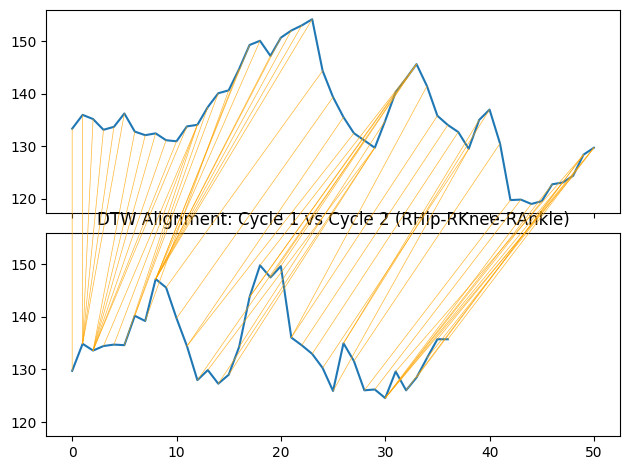

<Figure size 800x400 with 0 Axes>

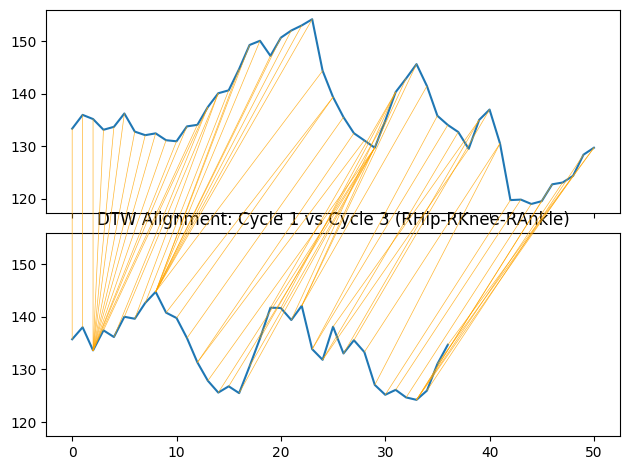

<Figure size 800x400 with 0 Axes>

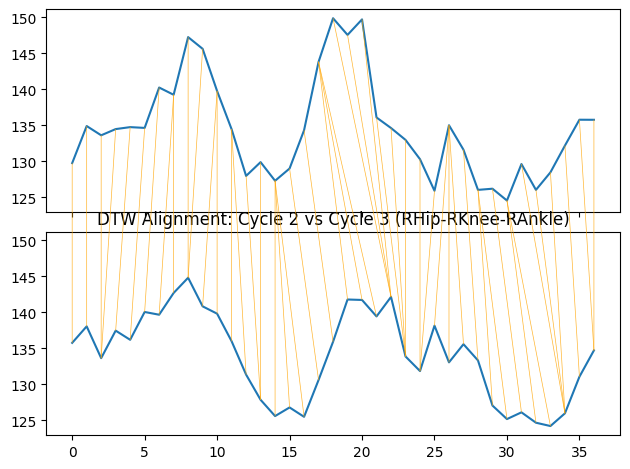

<Figure size 800x400 with 0 Axes>

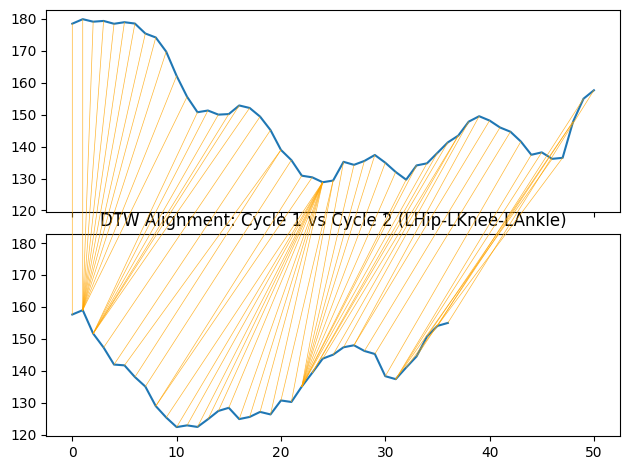

<Figure size 800x400 with 0 Axes>

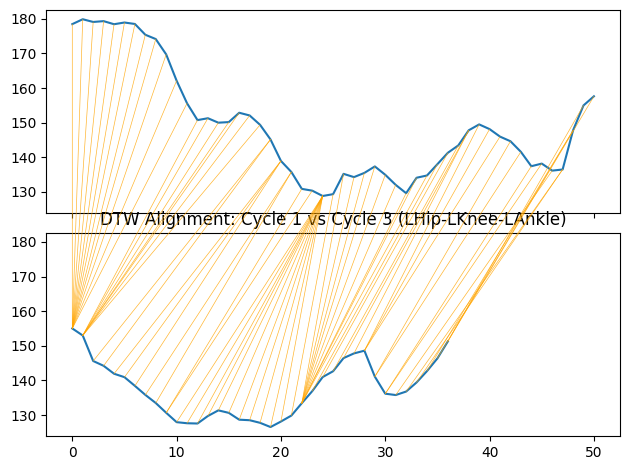

<Figure size 800x400 with 0 Axes>

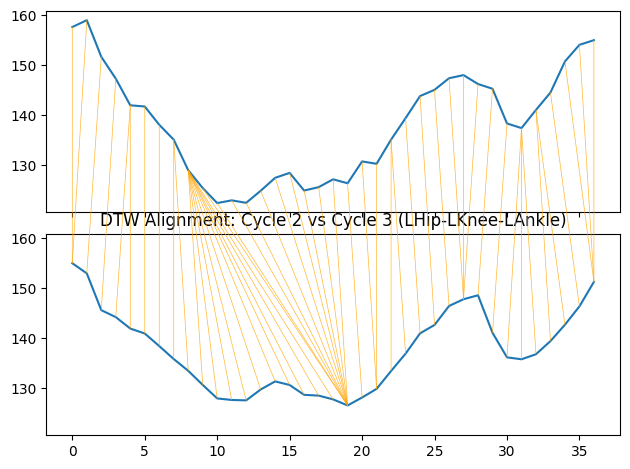

<Figure size 800x400 with 0 Axes>

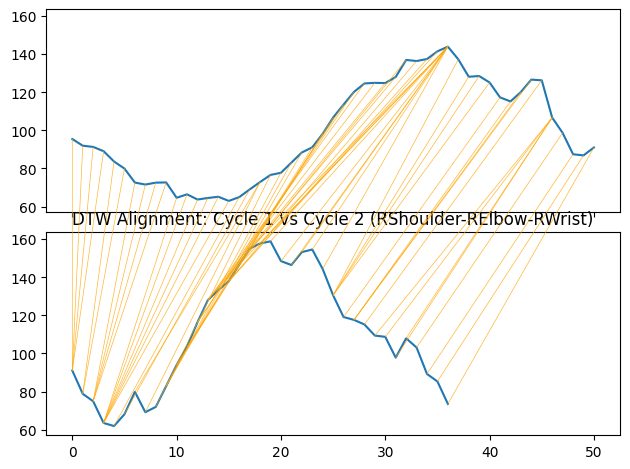

<Figure size 800x400 with 0 Axes>

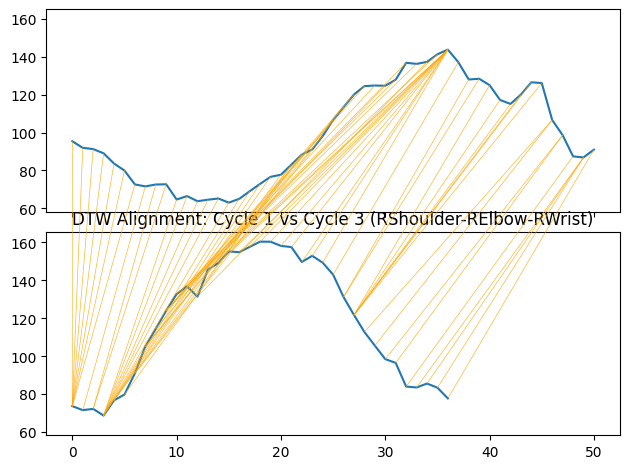

<Figure size 800x400 with 0 Axes>

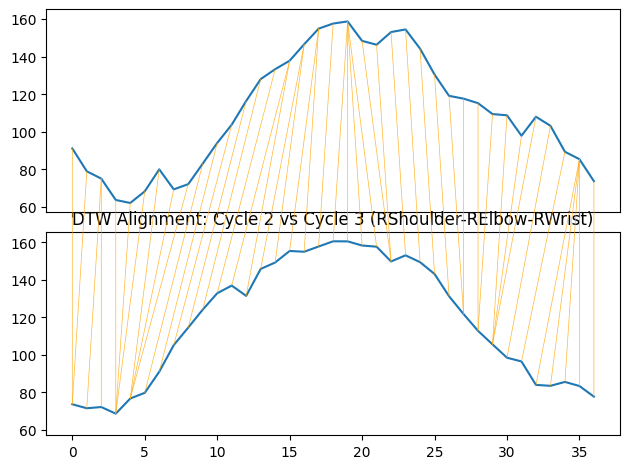

<Figure size 800x400 with 0 Axes>

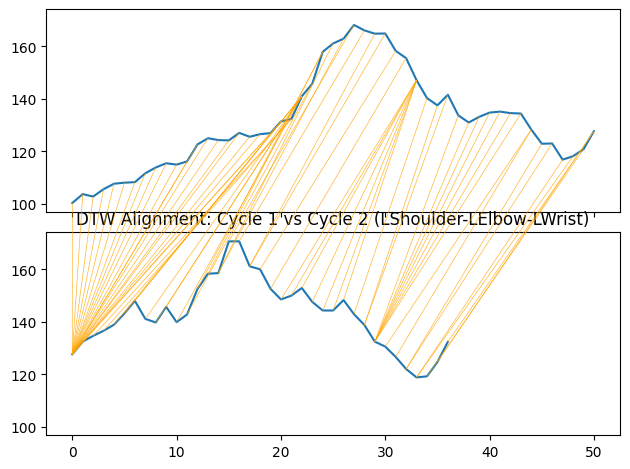

<Figure size 800x400 with 0 Axes>

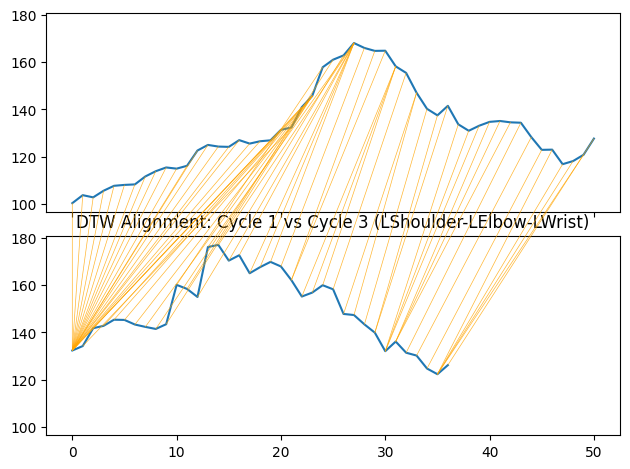

<Figure size 800x400 with 0 Axes>

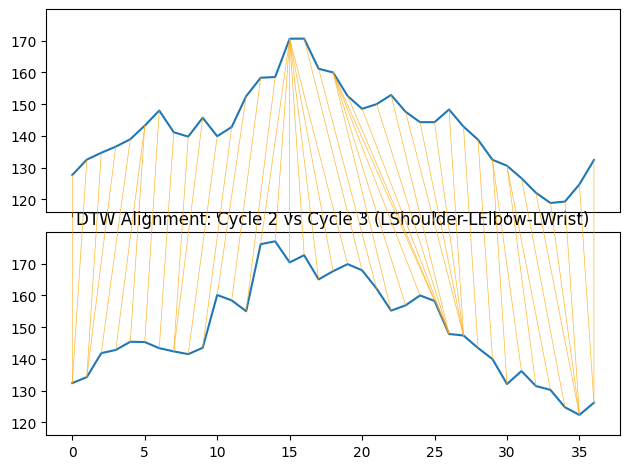

DTW Distance Cycle 1 vs Cycle 2 (RHip-RKnee-RAnkle): 23.04490413403837
DTW Distance Cycle 1 vs Cycle 3 (RHip-RKnee-RAnkle): 24.826548467737457
DTW Distance Cycle 2 vs Cycle 3 (RHip-RKnee-RAnkle): 19.028558370740598
DTW Distance Cycle 1 vs Cycle 2 (LHip-LKnee-LAnkle): 61.78998466290634
DTW Distance Cycle 1 vs Cycle 3 (LHip-LKnee-LAnkle): 72.89651729287007
DTW Distance Cycle 2 vs Cycle 3 (LHip-LKnee-LAnkle): 13.660364963252094
DTW Distance Cycle 1 vs Cycle 2 (RShoulder-RElbow-RWrist): 42.94899636975873
DTW Distance Cycle 1 vs Cycle 3 (RShoulder-RElbow-RWrist): 61.66817136130608
DTW Distance Cycle 2 vs Cycle 3 (RShoulder-RElbow-RWrist): 29.430494577330872
DTW Distance Cycle 1 vs Cycle 2 (LShoulder-LElbow-LWrist): 70.14075412335455
DTW Distance Cycle 1 vs Cycle 3 (LShoulder-LElbow-LWrist): 87.84086731447272
DTW Distance Cycle 2 vs Cycle 3 (LShoulder-LElbow-LWrist): 21.45024853685014


In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_visualisation

def load_cycles(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def compute_angle(p1, p2, p3):
    """Computes the angle between three points."""
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(dot_product / norm_product) * (180.0 / np.pi)

def extract_angle_series(cycle_data, joint1, joint2, joint3):
    """Extracts time-series data for an angle between three joints from a cycle."""
    angles = []
    for i in range(len(cycle_data[joint1 + "_x"])):
        p1 = (cycle_data[joint1 + "_x"][i], cycle_data[joint1 + "_y"][i])
        p2 = (cycle_data[joint2 + "_x"][i], cycle_data[joint2 + "_y"][i])
        p3 = (cycle_data[joint3 + "_x"][i], cycle_data[joint3 + "_y"][i])
        angles.append(compute_angle(p1, p2, p3))
    return np.array(angles)

def compare_cycles_angles(data, joint_triplets, gear_filter=None, visualize=False):
    """Compares movement cycles for specific joint angles using DTW and optionally visualizes the alignment."""
    dtw_results = {}
    cycles = {k: v for k, v in data.items() if gear_filter is None or v.get("Label") == gear_filter}
    cycle_keys = list(cycles.keys())
    
    for joint1, joint2, joint3 in joint_triplets:
        for i in range(len(cycle_keys)):
            for j in range(i + 1, len(cycle_keys)):
                cycle1 = extract_angle_series(cycles[cycle_keys[i]], joint1, joint2, joint3)
                cycle2 = extract_angle_series(cycles[cycle_keys[j]], joint1, joint2, joint3)
                dist = dtw.distance(cycle1, cycle2)
                path = dtw.warping_path(cycle1, cycle2)
                dtw_results[f"{cycle_keys[i]} vs {cycle_keys[j]} ({joint1}-{joint2}-{joint3})"] = dist
                
                if visualize:
                    plt.figure(figsize=(8, 4))
                    dtw_visualisation.plot_warping(cycle1, cycle2, path, filename=None)
                    plt.title(f"DTW Alignment: {cycle_keys[i]} vs {cycle_keys[j]} ({joint1}-{joint2}-{joint3})")
                    plt.show()
    
    return dtw_results

# Load cycle data
file_path = "../classification/cycle_splits/labeled_data/labeled_cycles_17_cut.json"
data = load_cycles(file_path)

# Define joint triplets for angle comparisons
joint_triplets = [("RHip", "RKnee", "RAnkle"), ("LHip", "LKnee", "LAnkle"), ("RShoulder", "RElbow", "RWrist"), ("LShoulder", "LElbow", "LWrist")]

# Compare angles for cycles within the same gear with visualization
dtw_comparisons = compare_cycles_angles(data, joint_triplets, gear_filter="gear2", visualize=True)

# Print DTW results
for comparison, distance in dtw_comparisons.items():
    print(f"DTW Distance {comparison}: {distance}")


In [ ]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_visualisation

def load_cycles(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def compute_angle(p1, p2, p3):
    """Computes the angle between three points."""
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(dot_product / norm_product) * (180.0 / np.pi)

def extract_angle_series(cycle_data, joint1, joint2, joint3):
    """Extracts time-series data for an angle between three joints from a cycle."""
    angles = []
    frames = []
    for i in range(len(cycle_data[joint1 + "_x"])):
        p1 = (cycle_data[joint1 + "_x"][i], cycle_data[joint1 + "_y"][i])
        p2 = (cycle_data[joint2 + "_x"][i], cycle_data[joint2 + "_y"][i])
        p3 = (cycle_data[joint3 + "_x"][i], cycle_data[joint3 + "_y"][i])
        angles.append(compute_angle(p1, p2, p3))
        frames.append(i)
    return np.array(angles), frames

# function to extract several angles at once
def extract_multivariate_series(cycle_data, joint_triplets):
    """Extracts multivariate time-series data for multiple angles from a cycle."""
    all_angles = []
    frames = []
    for i in range(len(cycle_data[joint_triplets[0][0] + "_x"])):
        angles = []
        for joint1, joint2, joint3 in joint_triplets:
            p1 = (cycle_data[joint1 + "_x"][i], cycle_data[joint1 + "_y"][i])
            p2 = (cycle_data[joint2 + "_x"][i], cycle_data[joint2 + "_y"][i])
            p3 = (cycle_data[joint3 + "_x"][i], cycle_data[joint3 + "_y"][i])
            angles.append(compute_angle(p1, p2, p3))
        all_angles.append(angles)
        frames.append(i)
    return np.array(all_angles), frames

def extract_frame(video_path, frame_idx):
    """Extracts and returns a specific frame from a video file."""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        return None

def overlay_frames_loop(video_path, path, cycle1_start_frame, cycle2_start_frame, series1, series2):
    """Overlays frames one by one with OpenCV and displays frame numbers."""
    if not path:
        print("No frames to overlay.")
        return
    
    for frame1, frame2 in path:

        f1 = extract_frame(video_path, frame1 + cycle1_start_frame)
        f2 = extract_frame(video_path, frame2 + cycle2_start_frame)
        if f1 is not None and f2 is not None:
            overlay = cv2.addWeighted(f1, 0.5, f2, 0.5, 0)
            overlay = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
            
            cv2.putText(overlay, f"Frame 1: {frame1}, angle: {series1[frame1]}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(overlay, f"Frame 2: {frame2}, angle: {series2[frame2]}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow("Overlayed Frames", overlay)
            
            if cv2.waitKey(0) & 0xFF == ord('q'):
                break
    
    cv2.destroyAllWindows()

def compare_selected_cycles(data, joint_triplets, video_path, cycle1_key, cycle2_key, use_multivariate=True, visualize=False):
    """Compares two selected movement cycles using DTW and optionally visualizes the alignment."""
    cycle1 = data.get(cycle1_key)
    cycle1_start_frame = cycle1.get("Start_frame")
    cycle2 = data.get(cycle2_key)
    cycle2_start_frame = cycle2.get("Start_frame")
    if not cycle1 or not cycle2:
        print("One or both selected cycles not found.")
        return {}
    
    dtw_results = {}
    
    if use_multivariate:
        
        # testing multivariate DTW
        series1_multi, frames1_multi = extract_multivariate_series(cycle1, joint_triplets)
        series2_multi, frames2_multi = extract_multivariate_series(cycle2, joint_triplets)
        
        dist = dtw.distance(series1_multi, series2_multi, use_ndim=True)
        path = dtw.warping_path(series1_multi, series2_multi, use_ndim=True)
        print(dist, path)
        
        dtw_results = {f"{cycle1_key} vs {cycle2_key} (Multivariate DTW)": dist}
        
    else:
        
        for joint1, joint2, joint3 in joint_triplets:
            # series is an array with all the angles
            series1, frames1 = extract_angle_series(cycle1, joint1, joint2, joint3)
            series2, frames2 = extract_angle_series(cycle2, joint1, joint2, joint3)
            # as I understand it this is the distance for the full signal => we could maybe have like a few expert cycles that are a little different
            # then choose the cycle we want to use for giving feedback based on that distance
            dist = dtw.distance(series1, series2)
            # path is an array of tuples showing which frames are being matched together. They start with 0 though so the start frame needs to be added 
            # to this!
            path = dtw.warping_path(series1, series2)
            print(dist, path)
            # here we save the results per joint
            dtw_results[f"{cycle1_key} vs {cycle2_key} ({joint1}-{joint2}-{joint3})"] = dist
        
    if visualize and not use_multivariate:
        # not sure if we could make that work for multidim? probably not
        plt.figure(figsize=(8, 4))
        dtw_visualisation.plot_warping(series1, series2, path, filename=None)
        plt.title(f"DTW Alignment: {cycle1_key} vs {cycle2_key} ({joint1}-{joint2}-{joint3})")
        plt.show()
        
        overlay_frames_loop(video_path, path, cycle1_start_frame, cycle2_start_frame, series1, series2)
        
    elif visualize:
        
        overlay_frames_loop(video_path, path, cycle1_start_frame, cycle2_start_frame, series1_multi, series2_multi)
    
    return dtw_results


# Load cycle data
file_path = "../classification/cycle_splits/labeled_data/labeled_cycles_17_cut.json"
video_path = r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\selectedData\DJI_0017_cut.mp4"  # Path to the corresponding video file
data = load_cycles(file_path)

# Define joint triplets for angle comparisons
joint_triplets = [("RHip", "RKnee", "RAnkle"), ("LHip", "LKnee", "LAnkle"), ("RShoulder", "RElbow", "RWrist"), ("LShoulder", "LElbow", "LWrist")]
#joint_triplets = [("RHip", "RKnee", "RAnkle")]


In [ ]:
# Define joint triplets for angle comparisons
joint_triplets = [("RHip", "RKnee", "RAnkle"), ("LHip", "LKnee", "LAnkle"), ("RShoulder", "RElbow", "RWrist"), ("LShoulder", "LElbow", "LWrist")]
#joint_triplets = [("RHip", "RKnee", "RAnkle")]

# User selects which cycles to compare
cycle1_key = input("Enter the first cycle key: ")
cycle2_key = input("Enter the second cycle key: ")

# Compare selected cycles
dtw_comparisons = compare_selected_cycles(data, joint_triplets, video_path, cycle1_key, cycle2_key, visualize=True)

# Print DTW results
for comparison, distance in dtw_comparisons.items():
    print(f"DTW Distance {comparison}: {distance}")
    

Multi dim = (51, 4)
Flattend: (204,)
146.11704967691298 [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 3), (13, 3), (14, 3), (15, 3), (16, 3), (17, 4), (18, 5), (19, 6), (20, 7), (21, 8), (22, 9), (23, 9), (24, 10), (25, 11), (26, 12), (27, 13), (28, 13), (29, 14), (30, 15), (31, 16), (32, 17), (32, 18), (32, 19), (33, 20), (34, 21), (35, 22), (36, 23), (37, 24), (38, 25), (39, 26), (40, 27), (41, 28), (42, 28), (43, 29), (44, 30), (45, 30), (46, 31), (46, 32), (47, 33), (48, 34), (49, 35), (50, 36)]
DTW Distance Cycle 1 vs Cycle 2 (Multivariate DTW): 146.11704967691298


In [11]:
# Define joint triplets for angle comparisons
joint_triplets = [("RHip", "RKnee", "RAnkle"), ("LHip", "LKnee", "LAnkle"), ("RShoulder", "RElbow", "RWrist"), ("LShoulder", "LElbow", "LWrist")]
#joint_triplets = [("RHip", "RKnee", "RAnkle")]

# User selects which cycles to compare
cycle1_key = input("Enter the first cycle key: ")
cycle2_key = input("Enter the second cycle key: ")

# Compare selected cycles
dtw_comparisons = compare_selected_cycles(data, joint_triplets, video_path, cycle1_key, cycle2_key, visualize=True)

# Print DTW results
for comparison, distance in dtw_comparisons.items():
    print(f"DTW Distance {comparison}: {distance}")

Multi dim = (37, 4)
Flattend: (148,)
81.33166324979341 [(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 3), (6, 4), (7, 4), (8, 5), (9, 6), (10, 7), (11, 8), (12, 9), (13, 10), (14, 11), (14, 12), (15, 13), (16, 14), (16, 15), (16, 16), (16, 17), (17, 18), (17, 19), (18, 20), (19, 21), (20, 22), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 28), (29, 29), (30, 30), (31, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 36)]
DTW Distance Cycle 2 vs Cycle 3 (Multivariate DTW): 81.33166324979341


<Figure size 800x400 with 0 Axes>

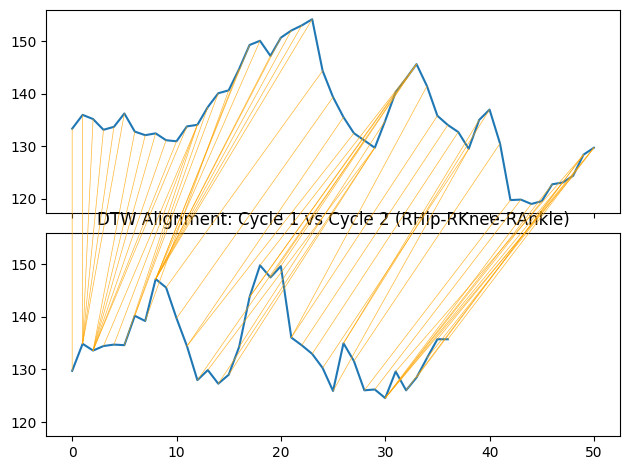

DTW Distance Cycle 1 vs Cycle 2 (RHip-RKnee-RAnkle): 23.04490413403837


In [4]:
joint_triplets = [("RHip", "RKnee", "RAnkle")]

# User selects which cycles to compare
cycle1_key = input("Enter the first cycle key: ")
cycle2_key = input("Enter the second cycle key: ")

# Compare selected cycles
dtw_comparisons = compare_selected_cycles(data, joint_triplets, video_path, cycle1_key, cycle2_key, use_multivariate=False, visualize=True)

# Print DTW results
for comparison, distance in dtw_comparisons.items():
    print(f"DTW Distance {comparison}: {distance}")

<Figure size 800x400 with 0 Axes>

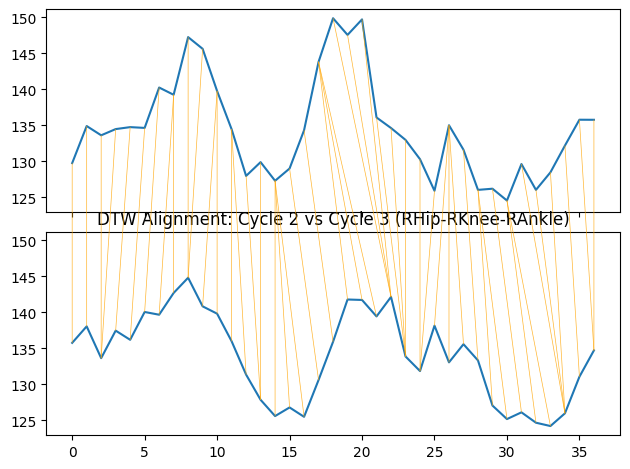

DTW Distance Cycle 2 vs Cycle 3 (RHip-RKnee-RAnkle): 19.028558370740598


In [10]:
joint_triplets = [("RHip", "RKnee", "RAnkle")]

# User selects which cycles to compare
cycle1_key = input("Enter the first cycle key: ")
cycle2_key = input("Enter the second cycle key: ")

# Compare selected cycles
dtw_comparisons = compare_selected_cycles(data, joint_triplets, video_path, cycle1_key, cycle2_key, use_multivariate=False, visualize=True)

# Print DTW results
for comparison, distance in dtw_comparisons.items():
    print(f"DTW Distance {comparison}: {distance}")